# <a id='toc1_'></a>[Specificity PR8 vs StPt](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Specificity PR8 vs StPt](#toc1_)    
  - [Data loading](#toc1_1_)    
  - [Split and filter data](#toc1_2_)    
    - [Split treated/control and filter infected cells](#toc1_2_1_)    
    - [QC: sample dropouts (no infected cells)](#toc1_2_2_)    
    - [Summarize spots per (infected) cell](#toc1_2_3_)    
    - [QC spot count outliers (failed segmentation):](#toc1_2_4_)    
  - [Spots per (infected) cell](#toc1_3_)    
    - [t-Tests for differences in mean](#toc1_3_1_)    
      - [PR8](#toc1_3_1_1_)    
      - [StPt](#toc1_3_1_2_)    
    - [QC consistency across replicates](#toc1_3_2_)    
  - [Median spot intensity](#toc1_4_)    
    - [QC intensity outliers](#toc1_4_1_)    
  - [Mean spot size](#toc1_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Summary](#toc0_)

The following settings are used:
- only spots from infected cells (at least 5 spots), discarding all other spots - exception: negative controls (cells are not infected so we keep all spots)
- include spots from the cytoplasm and the nucleus
- include inner cells and border cells in the analysis (see QC below)

In contrast to other samples we here
- do ignore spots from the bottom and left 10% of each FOV (neighboring fields of view have a slight overlap so spots from that region are only considered once), this avoids dependence between FOVs which would be problematic for statistical tests

General observations:
- probes are highly specific, there is almost no signal from probes designed for strains that are not present
- there are higher spot counts for PR8 compared to StPT, both in the single infections and in the co-infection

## <a id='toc1_1_'></a>[Data loading](#toc0_)

In [1]:
library(tidyverse)
library(patchwork)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
options(repr.plot.res = 300, repr.plot.width = 6, repr.plot.height = 4)
theme_set(theme_light())
theme_update(text = element_text(family = "Calibri"), strip.text = element_text(colour = 'black'))

In [3]:
# file generated in combind_csvs.ipynb
spots <- read_tsv("analysis/spot_detection/specificity/all_spots.tsv.xz", na="")

Rows: 63128 Columns: 23
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (4): rep, sample, fov, strain
dbl (17): intensity, z, y, x, radius, spot_id, z_min, z_max, y_min, y_max, x...
lgl  (2): nucleus, border_cell

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


To avoid multiple counting of spots in the overlap of tiles, only the top left 90% of each tile are used (this is not the ideal way to do this, as it also removes regions from border FOVs that have no overlap).

In [4]:
spots <- spots %>% filter(x<=1800, y<=1800)

## <a id='toc1_2_'></a>[Split and filter data](#toc0_)

For negative controls, all spots are used and the number of spots per cell is calculated. For all other samples, only spots from *infected* cells are used and the number of spots per infected cell is calculated.
A cell is defined as *infected* if at least 5 spots are assigned to that cell, including the nucleus.

### <a id='toc1_2_1_'></a>[Split treated/control and filter infected cells](#toc0_)

In [5]:
pos_spots <- spots %>%
	filter(!str_detect(sample,"NegCtrl")) %>%
	group_by(rep,sample,fov,cell) %>%
	filter(n()>=5) %>%
	group_by(rep,sample,fov) %>%
	mutate(infected_cells=n_distinct(cell)) %>%
	ungroup

In [6]:
neg_spots <- spots %>%
	filter(str_detect(sample,"NegCtrl"))

### <a id='toc1_2_2_'></a>[QC: sample dropouts (no infected cells)](#toc0_)

After filtering cells with less than 5 spots, some samples may be lost as they don't contain any infected cells

In [7]:
get_fovs <- . %>% ungroup %>% select(rep,sample,fov) %>% unique

In [8]:
fovs_no_infected_cells <- get_fovs(spots %>% filter(!str_detect(sample,"NegCtrl"))) %>% anti_join(get_fovs(pos_spots))
fovs_no_infected_cells

Joining with `by = join_by(rep, sample, fov)`


rep,sample,fov
<chr>,<chr>,<chr>


### <a id='toc1_2_3_'></a>[Summarize spots per (infected) cell](#toc0_)

In [9]:
pos_spots_summary <- pos_spots %>% group_by(rep,sample,fov,strain,infected_cells) %>% summarize(spots = n(), median_intensity=median(intensity), mean_radius=median(radius)) %>% mutate(spots_per_infected_cell = spots/infected_cells)
neg_spots_summary <- neg_spots %>% group_by(rep,sample,fov,strain,n_cells) %>% summarize(spots = n(), median_intensity=median(intensity), mean_radius=median(radius)) %>% mutate(spots_per_cell = spots/n_cells)

`summarise()` has grouped output by 'rep', 'sample', 'fov', 'strain'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'rep', 'sample', 'fov', 'strain'. You can
override using the `.groups` argument.


### <a id='toc1_2_4_'></a>[QC spot count outliers (failed segmentation):](#toc0_)

In some cases the segmentation failed and very few nuclei were detected, therefore the spots/cell count is massively inflated. Those samples need to be filtered.

In [10]:
pos_spots_summary %>% filter(spots_per_infected_cell>1000)

rep,sample,fov,strain,infected_cells,spots,median_intensity,mean_radius,spots_per_infected_cell
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>


In [11]:
pos_spots_summary <- pos_spots_summary %>% filter(spots_per_infected_cell < 1000)
neg_spots_summary <- neg_spots_summary %>% filter(spots_per_cell < 1000)

## <a id='toc1_3_'></a>[Spots per (infected) cell](#toc0_)

In [12]:
pos_plot <- pos_spots_summary %>%
	ggplot(aes(sample,spots_per_infected_cell, color=strain))+
		geom_boxplot(outlier.shape = NA) +
		geom_point(position=position_jitterdodge()) +
		ylim(0,52) +
		ylab("RCPs per infected cell") +
		NULL

In [13]:
ggsave("figures/fig1e-specificity-spot_counts.svg", width = 4.5, height = 4, dpi = 300)

In [14]:
neg_plot <- neg_spots_summary %>%
	ggplot(aes(sample,spots_per_cell, color=strain))+
		geom_boxplot(outlier.shape = NA) +
		geom_point(position=position_jitterdodge()) +
		ylim(0,52) +
		ylab("RCPs per cell") +
		NULL

In [15]:
ggsave("figures/supp-fig1d-specificity-spot_counts-neg_ctrl.svg", width = 2, height = 4, dpi = 300)

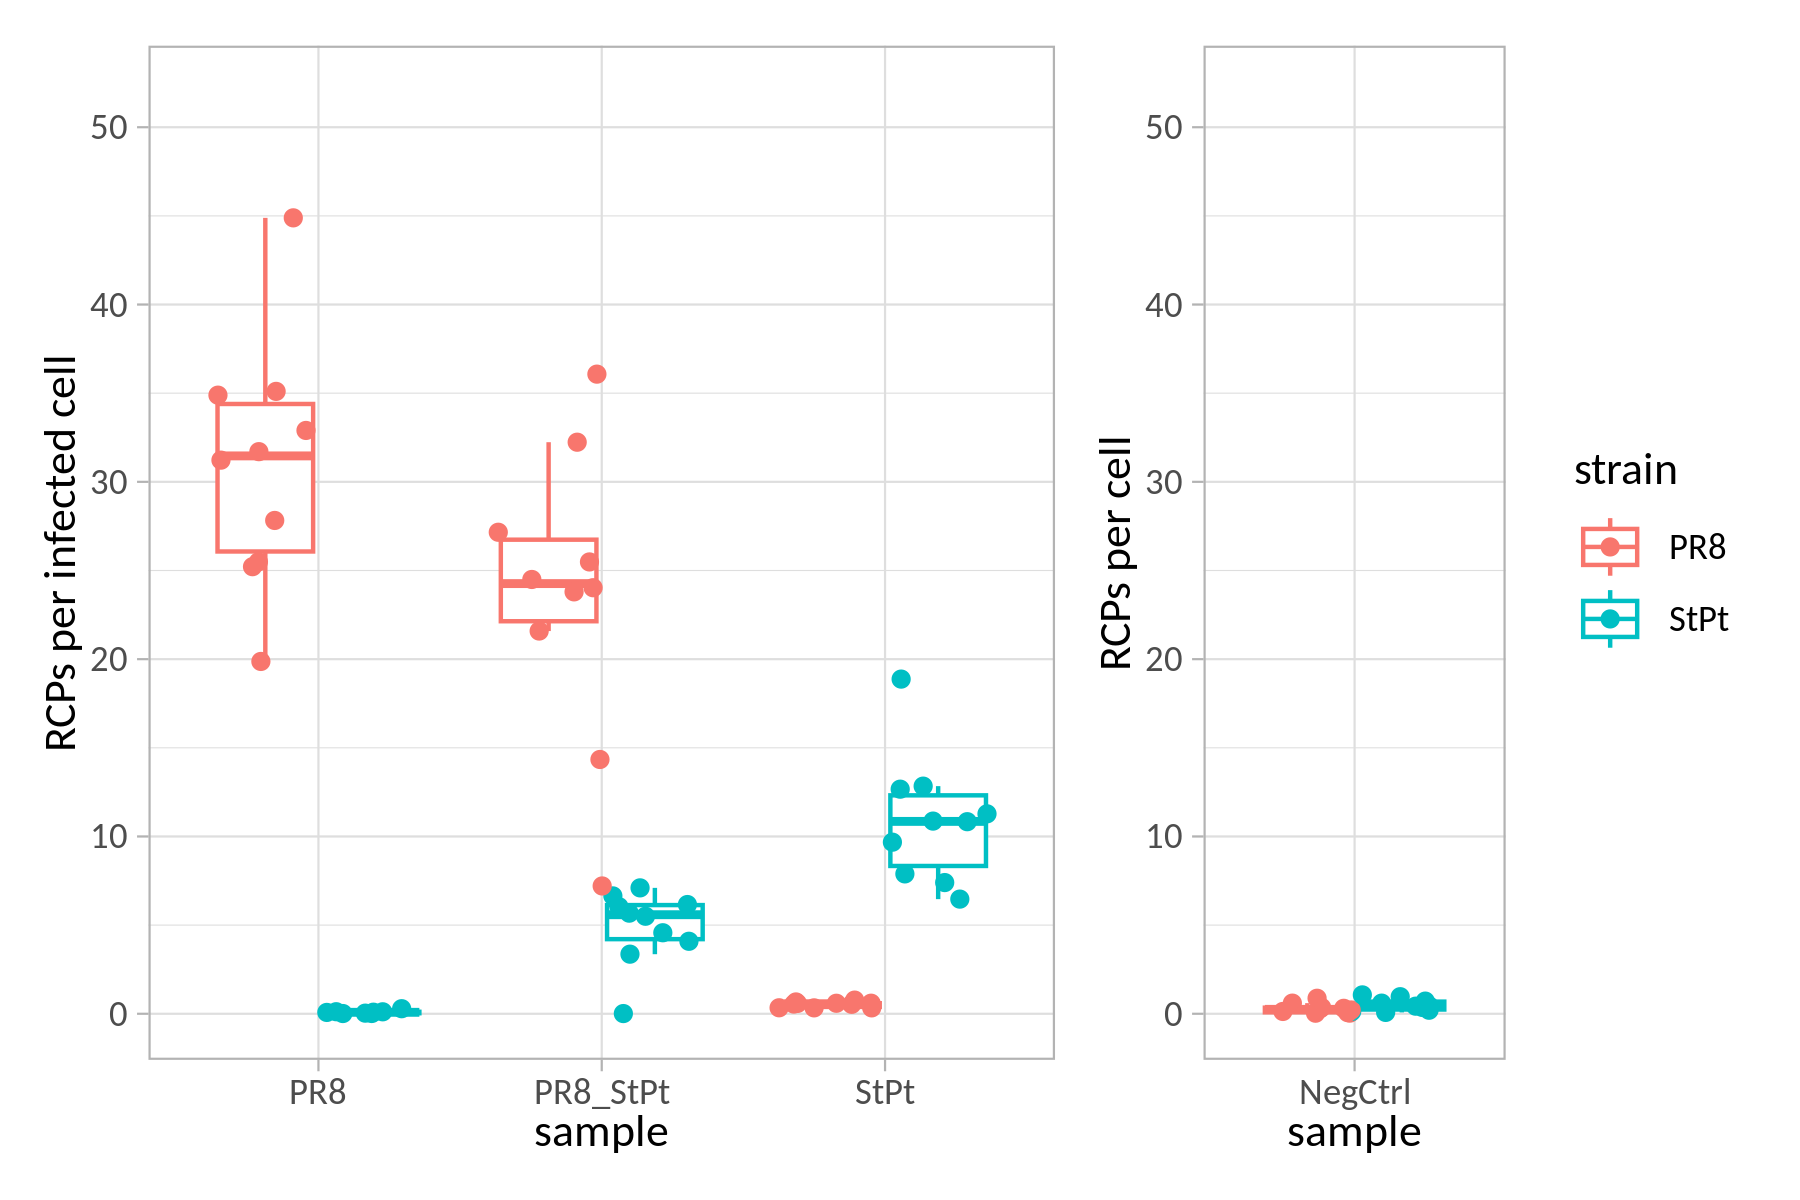

In [16]:
# only use a single legend
pos_plot + neg_plot + plot_layout(widths = c(3, 1), guides="collect")